In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ray

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

root_dir = '../exp_results/baseline_correct'

In [2]:
state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (RPC, {}, '1min'),
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

In [3]:
from rl_trading.utils import load_model
from tqdm import tqdm
import pickle

ray.logger.setLevel('ERROR')

def load_checkpoints():
    checkpoints = {}
    for alg_name in os.listdir(root_dir):
        checkpoints[alg_name] = {}
        for exp_name in os.listdir(os.path.join(root_dir, alg_name)):
            seed = int(re.findall('seed=([0-9]+)', exp_name)[0])
            checkpoints[alg_name][seed] = {}
            for result_dir in os.listdir(os.path.join(root_dir, alg_name, exp_name)):
                if 'steps' in result_dir:
                    sequence_len = int(re.findall('steps=([0-9]+)', result_dir)[0])
                elif 'days' in result_dir:
                    sequence_len = int(re.findall('days=([0-9]+)', result_dir)[0]) * 1440
                else:
                    continue

                for file in os.listdir(os.path.join(root_dir, alg_name, exp_name, result_dir)):
                    if 'checkpoint' in file:
                       checkpoints[alg_name][seed][sequence_len] = os.path.join(root_dir, alg_name, exp_name, result_dir, file)
    return checkpoints

def save_eval_results(results):
    with open('eval_results.json', 'wb') as f:
        pickle.dump(results, f)

def load_eval_results():
    if os.path.exists('eval_results.json'):
        print('Loading existing evaluation results')
        with open('eval_results.json', 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}
    return results

def evaluate_policies(checkpoints):
    eval_results = load_eval_results()
    total = sum([10 for alg_name in checkpoints for seed in checkpoints[alg_name] for sequence_len in checkpoints[alg_name][seed]])
    with tqdm(total=total) as pbar:
        for alg_name in checkpoints:
            if alg_name not in eval_results:
                eval_results[alg_name] = {}
            for seed in checkpoints[alg_name]:
                if seed not in eval_results[alg_name]:
                    eval_results[alg_name][seed] = {}
                print(f'Evaluating alg: {alg_name}')
                for sequence_len, checkpoint in checkpoints[alg_name][seed].items():
                    if alg_name in eval_results and seed in eval_results[alg_name] and sequence_len in eval_results[alg_name][seed]:
                        pbar.update(10)
                        continue
                    max_steps = sequence_len if sequence_len < 1440 else 1440
                    n_days = 1 if sequence_len < 1440 else sequence_len // 1440
                    try:
                        model = load_model(checkpoint)
                    except Exception as e:
                        print(checkpoint)
                        raise e
                    sim_env = StockExchangeEnv0(
                        sim_config={'max_steps': max_steps},
                        state_config=state_config,
                        _n_days=n_days,
                        seed=seed
                    )
                    eval_env = StockExchangeEnv0(
                        sim_config={'max_steps': max_steps},
                        state_config=state_config,
                        _n_days=n_days,
                        seed=seed
                    )
                    model_results = []
                    baseline_results = []
                    for i in range(10):
                        sim_env.reset()
                        eval_env.reset()
                        sim_env.start_idx = sim_env._idxs_range[0] + 1440 * (i + 1)
                        eval_env.start_idx = sim_env._idxs_range[0] + 1440 * (i + 1)
                        assert sim_env.start_idx not in sim_env._idxs_range
                        state = sim_env._get_observation()

                        done = False
                        reward_total = 0
                        baseline_reward = 0
                        rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
                        prev_action, prev_reward = 0, 0

                        while not done:
                            current_idx = eval_env.current_idx
                            current_price = eval_env.price_data['1min'][current_idx]
                            next_price = eval_env.price_data['1min'][current_idx + 1]
                            if next_price > current_price:
                                action = 1
                            elif next_price < current_price:
                                action = 2
                            else:
                                action = 0
                            _, reward, done, _, _ = eval_env.step(action)
                            baseline_reward += reward

                            if 'R2D2' in alg_name:
                                action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward, explore=False)
                            else:
                                action = model.compute_single_action(state, explore=False)
                            state, reward, done, _, _ = sim_env.step(action)
                            prev_action = action
                            prev_reward = reward
                            reward_total += reward
                        model_results.append(reward_total)
                        baseline_results.append(baseline_reward)
                        pbar.update(1)
                    print('sequence len:', sequence_len)
                    print('baseline_reward:', np.mean(baseline_results))
                    print('reward_total:', np.mean(model_results))
                    eval_results[alg_name][seed][sequence_len] = (np.mean(model_results), np.mean(baseline_results))
                    save_eval_results(eval_results)
                    del model
    return eval_results

In [4]:
checkpoints = load_checkpoints()
eval_results = evaluate_policies(checkpoints)

Loading existing evaluation results


  0%|          | 0/2210 [00:00<?, ?it/s]

Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: R2D2
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: PPO
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: SAC
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN
Evaluating alg: DQN


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprec

sequence len: 7200
baseline_reward: 5914.417389232711
reward_total: 633.4014569415103


(RolloutWorker pid=2824555) 2023-06-26 13:18:00,938	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:18:01,223	INFO trainable.py:173 -- Trainable.setup took 12.151 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 93%|█████████▎| 2060/2210 [01:23<00:25,  5.79it/s]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 30
baseline_reward: 82.47131789423057
reward_total: -7.399576046733091


(RolloutWorker pid=2826363) 2023-06-26 13:18:14,982	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:18:15,279	INFO trainable.py:173 -- Trainable.setup took 12.873 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 94%|█████████▎| 2070/2210 [01:45<02:24,  1.03s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 300
baseline_reward: 926.3288021929208
reward_total: -19.402030485850084


(RolloutWorker pid=2829348) 2023-06-26 13:18:35,805	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:18:36,026	INFO trainable.py:173 -- Trainable.setup took 10.981 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 94%|█████████▍| 2080/2210 [02:45<10:44,  4.96s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 934560
baseline_reward: 3764.4031520400763
reward_total: 114.30592135738297


(RolloutWorker pid=2836968) 2023-06-26 13:19:36,121	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:19:36,417	INFO trainable.py:173 -- Trainable.setup took 11.840 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 95%|█████████▍| 2090/2210 [03:45<09:59,  4.99s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 2102400
baseline_reward: 6847.277406838143
reward_total: 528.3918552795133


(RolloutWorker pid=2845037) 2023-06-26 13:20:36,430	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:20:36,867	INFO trainable.py:173 -- Trainable.setup took 11.851 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 95%|█████████▌| 2100/2210 [04:47<09:14,  5.04s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 82080
baseline_reward: 4732.175032723317
reward_total: 352.860365038268


(RolloutWorker pid=2853432) 2023-06-26 13:21:38,979	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:21:39,398	INFO trainable.py:173 -- Trainable.setup took 12.304 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 95%|█████████▌| 2110/2210 [05:20<03:49,  2.30s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 600
baseline_reward: 2207.685170605341
reward_total: 99.09575418065796


(RolloutWorker pid=2858029) 2023-06-26 13:22:11,919	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:22:12,406	INFO trainable.py:173 -- Trainable.setup took 12.113 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 96%|█████████▌| 2120/2210 [05:33<01:13,  1.22it/s]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 10
baseline_reward: 24.35640717743081
reward_total: 1.4438341539893371


(RolloutWorker pid=2859849) 2023-06-26 13:22:24,341	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:22:25,105	INFO trainable.py:173 -- Trainable.setup took 12.220 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 96%|█████████▋| 2130/2210 [06:37<06:30,  4.88s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 2880
baseline_reward: 5896.832063233568
reward_total: 179.81234925247063


(RolloutWorker pid=2868798) 2023-06-26 13:23:28,710	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:23:29,310	INFO trainable.py:173 -- Trainable.setup took 12.130 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 97%|█████████▋| 2140/2210 [07:39<05:57,  5.11s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 36000
baseline_reward: 5535.716539504661
reward_total: 602.0269610803032


(RolloutWorker pid=2877519) 2023-06-26 13:24:30,983	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:24:31,305	INFO trainable.py:173 -- Trainable.setup took 12.016 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 97%|█████████▋| 2150/2210 [08:42<05:20,  5.34s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 15840
baseline_reward: 5813.098967443411
reward_total: 539.0329898679522


(RolloutWorker pid=2886404) 2023-06-26 13:25:34,161	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:25:34,384	INFO trainable.py:173 -- Trainable.setup took 12.393 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 98%|█████████▊| 2160/2210 [09:46<04:33,  5.46s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 416160
baseline_reward: 3619.808958910752
reward_total: 342.74915828066366


(RolloutWorker pid=2895598) 2023-06-26 13:26:38,163	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:26:38,615	INFO trainable.py:173 -- Trainable.setup took 12.480 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 98%|█████████▊| 2170/2210 [10:51<03:35,  5.38s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 184320
baseline_reward: 3559.254416153685
reward_total: 260.73526132538956


(RolloutWorker pid=2905118) 2023-06-26 13:27:42,618	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:27:43,132	INFO trainable.py:173 -- Trainable.setup took 12.483 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 99%|█████████▊| 2180/2210 [11:06<00:15,  1.92it/s]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 60
baseline_reward: 161.3256870207435
reward_total: -5.57675819318556


(RolloutWorker pid=2907352) 2023-06-26 13:27:58,036	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:27:58,333	INFO trainable.py:173 -- Trainable.setup took 12.912 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 99%|█████████▉| 2190/2210 [11:24<00:12,  1.54it/s]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 120
baseline_reward: 326.5884234870802
reward_total: -3.676607039301234


(RolloutWorker pid=2910138) 2023-06-26 13:28:15,792	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:28:16,065	INFO trainable.py:173 -- Trainable.setup took 12.440 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 99%|█████████▉| 2196/2210 [11:36<00:19,  1.36s/it]/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is depr

sequence len: 5
baseline_reward: 10.0336474802647
reward_total: -0.902723024813713


(RolloutWorker pid=2912121) 2023-06-26 13:28:28,165	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-26 13:28:28,874	INFO trainable.py:173 -- Trainable.setup took 12.458 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
100%|██████████| 2210/2210 [12:41<00:00,  2.90it/s]

sequence len: 1440
baseline_reward: 5841.512781375053
reward_total: 574.0593242631485


In [5]:
results = []

for alg_name in eval_results:
    for seed in eval_results[alg_name]:
        for seq_len, (eval_reward, baseline_reward) in eval_results[alg_name][seed].items():
            results.append((alg_name, seq_len, seed, eval_reward, baseline_reward))

df = pd.DataFrame(results, columns=['alg_name', 'sequence_len', 'seed', 'eval_reward', 'baseline_reward'])
df = df.sort_values(['alg_name', 'sequence_len', 'seed'], ascending=[True, True, True])

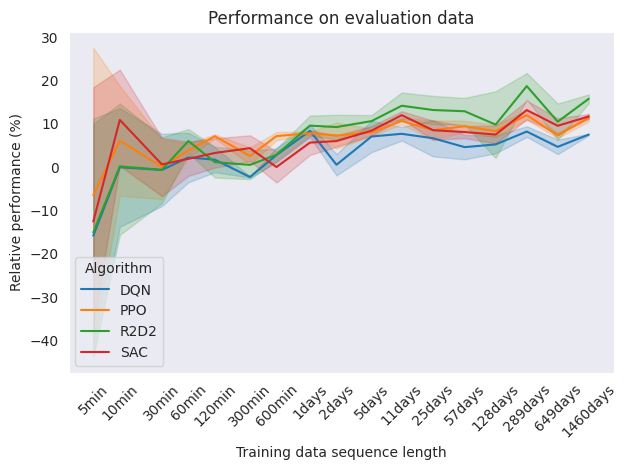

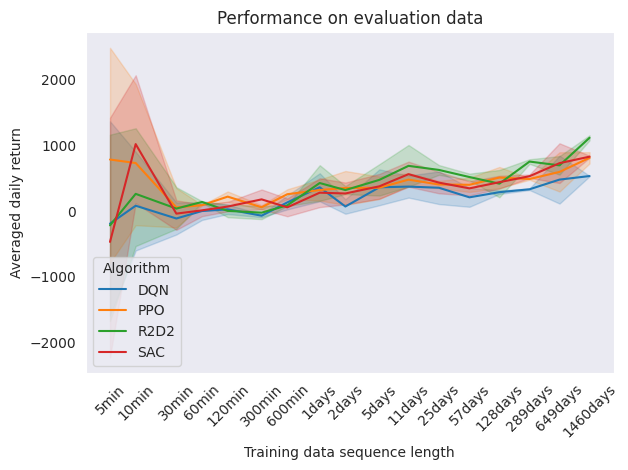

In [6]:
df['normalized_return'] = df['eval_reward'] / df['baseline_reward'] * 100
df['adjusted_return'] = df['eval_reward'] * 1440 / np.clip(df['sequence_len'], 0, 1440)

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='sequence_len', y='normalized_return', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Relative performance (%)')
plt.title('Performance on evaluation data')
plt.legend(title='Algorithm')
ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_eval_normalized.pdf')
plt.savefig('benchmark_eval_normalized.png')
plt.show()

plt.close()

sns.lineplot(x='sequence_len', y='adjusted_return', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Averaged daily return')
plt.title('Performance on evaluation data')
plt.legend(title='Algorithm')
ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_eval_adjusted.pdf')
plt.savefig('benchmark_eval_adjusted.png')
plt.show()

plt.close()

In [10]:
display(df[df['alg_name'] == 'SAC'])

,alg_name,sequence_len,seed,eval_reward,baseline_reward,normalized_return,adjusted_return
120,SAC,5,1,-1.208003,5.497605,-21.973257,-347.904837
162,SAC,5,2,-6.609202,11.391574,-58.018334,-1903.450056
169,SAC,5,3,-2.334868,31.065364,-7.515986,-672.442090
160,SAC,5,4,16.505835,22.291421,74.045685,4753.680548
166,SAC,5,5,-15.450417,40.048971,-38.578812,-4449.720101
141,SAC,5,42,-1.572044,10.033647,-15.667726,-452.748793
128,SAC,5,52,-0.688013,3.464519,-19.858819,-198.147608
121,SAC,10,1,0.747237,13.832535,5.402024,107.602104
161,SAC,10,2,-0.637551,24.371957,-2.615920,-91.807342
170,SAC,10,3,9.956545,46.899294,21.229628,1433.742545


In [34]:
def load_eval_results(path):
    eval_results = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'evaluation' in data:
                eval_results.append(data)

    if len(eval_results) == 0:
        print(path)
    return eval_results

eval_exps = {
    'No fee': '/home/fassty/Devel/school/diploma_thesis/code/exp_results/discrete_env_21ind_normalized/R2D2_stored/R2D2_StockExchangeEnv-v0_bb722_00000_0_2023-05-14_22-56-05/',
    'fee 0.001%': '/home/fassty/Devel/school/diploma_thesis/code/exp_results/discrete_env_21ind_normalized_fee1e-3/R2D2_stored/R2D2_StockExchangeEnv-v0_44106_00000_0_2023-05-16_08-38-32'
}

eval_results = {}
for exp_name, checkpoint_dir in eval_exps.items():
    eval_results[exp_name] = load_eval_results(os.path.join(checkpoint_dir, 'result.json'))

eval_results

{'No fee': [{'evaluation': {'episode_reward_max': 2941.1417108907262,
    'episode_reward_min': -19.17224636627725,
    'episode_reward_mean': 683.7744646286067,
    'episode_len_mean': 1440.0,
    'episode_media': {},
    'episodes_this_iter': 40,
    'policy_reward_min': {},
    'policy_reward_max': {},
    'policy_reward_mean': {},
    'custom_metrics': {},
    'hist_stats': {'episode_reward': [538.7852954954033,
      195.14239409497532,
      292.14632636862734,
      777.2437956344202,
      1310.1563428942773,
      49.200638611358954,
      170.67888298438083,
      2212.790731184794,
      746.4450362505304,
      1746.6109410373083,
      451.1764972386918,
      358.9878422038182,
      254.04967358737485,
      397.3897898490486,
      675.4738395661952,
      817.5211559198142,
      -19.17224636627725,
      1285.357246119349,
      819.0683526397552,
      2941.1417108907262,
      1072.5510049088134,
      320.44899537560923,
      396.73849154693926,
      381.19159696

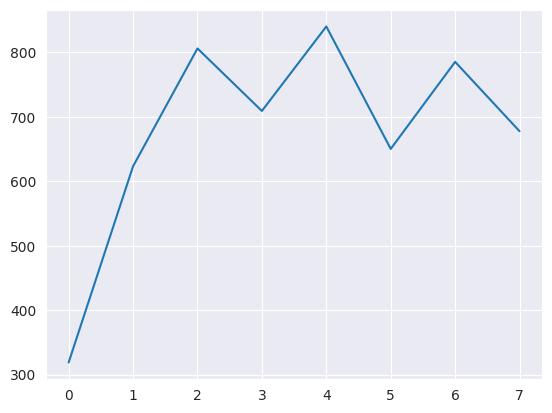

In [35]:
mean_returns = [res['episode_reward_mean'] for res in eval_results['No fee']]

plt.plot(mean_returns)

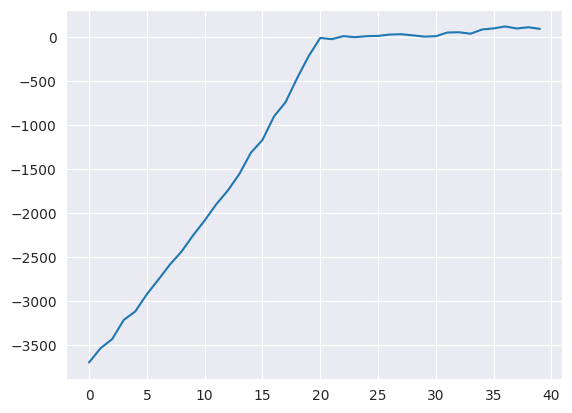

In [36]:
mean_returns = [res['episode_reward_mean'] for res in eval_results['fee 0.001%']]

plt.plot(mean_returns)